In [1]:
# SparkSession
from pyspark.sql import SparkSession
from seaborn import heatmap

spark = SparkSession.builder.master("local") \
                            .appName("PCA_ML_Lib") \
                            .getOrCreate()

22/08/22 02:15:51 WARN Utils: Your hostname, Druk.local resolves to a loopback address: 127.0.0.1; using 192.168.29.153 instead (on interface en0)
22/08/22 02:15:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/22 02:15:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load the [Wine Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine)

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
X = wine.data

In [3]:
import pandas as pd
df = pd.DataFrame(X, columns=wine.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## Create a Spark DataFrame

In [4]:
df = spark.createDataFrame(df)

In [5]:
df.show(5)

+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|od280/od315_of_diluted_wines|proline|
+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|  14.23|      1.71|2.43|             15.6|    127.0|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92| 1065.0|
|   13.2|      1.78|2.14|             11.2|    100.0|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                         3.4| 1050.0|
|  13.16|      2.36|2.67|             18.6|    101.0|          2.8|      3.24|                 0.3|           2.81|           5.68

In [6]:
df.printSchema()

root
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: double (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- od280/od315_of_diluted_wines: double (nullable = true)
 |-- proline: double (nullable = true)



## Get the RDD

In [7]:
rdd = df.rdd

## Convert the RDD into a [`RowMatrix`](https://spark.apache.org/docs/2.2.0/api/java/org/apache/spark/mllib/linalg/distributed/RowMatrix.html)

In [8]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors

In [9]:
vectors = rdd.map(Vectors.dense)
matrix = RowMatrix(vectors)

## Get the PCs of the matrix

In [10]:
pc = matrix.computePrincipalComponents(len(df.columns))

22/08/22 02:15:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/08/22 02:15:55 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/08/22 02:15:55 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/08/22 02:15:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/08/22 02:15:55 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [11]:
pc

DenseMatrix(13, 13, [-0.0017, 0.0007, -0.0002, 0.0047, -0.0179, -0.001, -0.0016, 0.0001, ..., 0.0267, -0.0696, -0.9665, 0.0176, 0.0046, 0.1666, -0.0442, -0.0], 0)

In [12]:
matrix_reduced = matrix.multiply(pc)

In [13]:
matrix_reduced.numCols()

13

In [14]:
import numpy as np
x_red = np.array(matrix_reduced.rows.collect())

In [15]:
import matplotlib.pyplot as plt

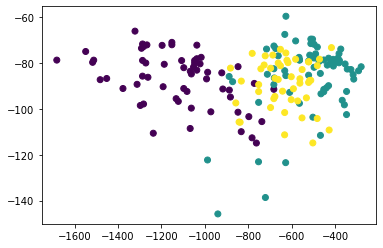

In [16]:
plt.scatter(x_red[:, 0], x_red[:, 1], c=wine.target)

## Verify with sklearn

In [17]:
from sklearn.decomposition import PCA

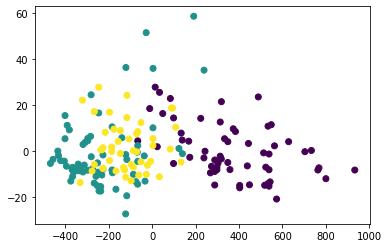

In [18]:
pca = PCA()
x_red = pca.fit_transform(wine.data)
plt.scatter(x_red[:, 0], x_red[:, 1], c=wine.target)

## Question: Why the difference in the scatter plots?
### (Hint: Look at the limits of the axes)

## New Housing Data

In [19]:
df = pd.read_csv("newhousing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
0,5250000,5500,3,2,1,1,0,1,0,0,0,0,1,0,1833.333333,0.666667
1,4480000,4040,3,1,2,1,0,0,0,0,1,0,1,0,1346.666667,0.333333
2,3570000,3640,2,1,1,1,0,0,0,0,0,0,0,1,1820.000000,0.500000
3,2870000,3040,2,1,1,0,0,0,0,0,0,0,0,1,1520.000000,0.500000
4,3570000,4500,2,1,1,0,0,0,0,0,0,0,0,0,2250.000000,0.500000


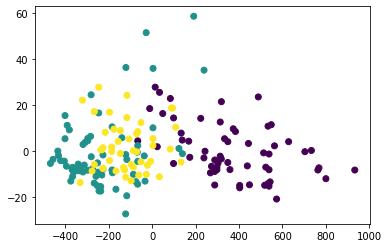

In [20]:
pca = PCA()
x_red = pca.fit_transform(wine.data)
plt.scatter(x_red[:, 0], x_red[:, 1], c=wine.target)

In [21]:
#Normalization of the dataset.
x_centered = df - df.mean(axis=0)
x_scaled = x_centered / x_centered.std(axis=0)
print("Column-wise mean", x_scaled.mean(axis=0))
print("Column-wise variance", x_scaled.var(axis=0))

#convert the array into dataframe.
df = pd.DataFrame(x_scaled)

#calculate the covariance matrix of ‘df’
df.cov()

Column-wise mean price              1.890435e-16
area              -1.417826e-16
bedrooms          -1.955622e-16
bathrooms         -5.866867e-17
stories           -1.042999e-16
mainroad          -9.126237e-17
guestroom         -4.889056e-18
basement          -1.499310e-16
hotwaterheating   -1.303748e-17
airconditioning   -3.911244e-17
parking            8.148426e-19
prefarea           5.866867e-17
semi-furnished    -5.866867e-17
unfurnished       -6.192804e-17
areaperbedroom     1.205967e-16
bbratio           -5.866867e-17
dtype: float64
Column-wise variance price              1.0
area               1.0
bedrooms           1.0
bathrooms          1.0
stories            1.0
mainroad           1.0
guestroom          1.0
basement           1.0
hotwaterheating    1.0
airconditioning    1.0
parking            1.0
prefarea           1.0
semi-furnished     1.0
unfurnished        1.0
areaperbedroom     1.0
bbratio            1.0
dtype: float64


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished,areaperbedroom,bbratio
price,1.000000,0.535997,0.366494,0.517545,0.420712,0.296898,0.255517,0.187057,0.093073,0.452954,0.384394,0.329777,0.063656,-0.280587,0.244809,0.231732
area,0.535997,1.000000,0.151858,0.193820,0.083996,0.288874,0.140297,0.047417,-0.009229,0.222393,0.352980,0.234779,0.006156,-0.142278,0.805610,0.057116
bedrooms,0.366494,0.151858,1.000000,0.373930,0.408564,-0.012033,0.080549,0.097312,0.046049,0.160603,0.139270,0.079023,0.050040,-0.126252,-0.397259,-0.317303
bathrooms,0.517545,0.193820,0.373930,1.000000,0.326165,0.042398,0.126469,0.102106,0.067159,0.186915,0.177496,0.063472,0.029834,-0.132107,-0.052352,0.727154
stories,0.420712,0.083996,0.408564,0.326165,1.000000,0.121706,0.043538,-0.172394,0.018847,0.293602,0.045547,0.044425,-0.003648,-0.082972,-0.178942,0.032962
mainroad,0.296898,0.288874,-0.012033,0.042398,0.121706,1.000000,0.092337,0.044002,-0.011781,0.105423,0.204433,0.199876,0.011450,-0.133123,0.249829,0.030407
guestroom,0.255517,0.140297,0.080549,0.126469,0.043538,0.092337,1.000000,0.372066,-0.010308,0.138179,0.037466,0.160897,0.005821,-0.099023,0.054312,0.075854
basement,0.187057,0.047417,0.097312,0.102106,-0.172394,0.044002,0.372066,1.000000,0.004385,0.047341,0.051497,0.228083,0.050284,-0.117935,-0.017034,0.047346
hotwaterheating,0.093073,-0.009229,0.046049,0.067159,0.018847,-0.011781,-0.010308,0.004385,1.000000,-0.130023,0.067864,-0.059411,0.063819,-0.059194,-0.021634,0.021520
airconditioning,0.452954,0.222393,0.160603,0.186915,0.293602,0.105423,0.138179,0.047341,-0.130023,1.000000,0.159173,0.117382,-0.053179,-0.094086,0.096830,0.064649
